# Exponential noise

## Problem setting:
Find any way of solving linear regression problem with exponentially distributed error (that is better than ordinary linear regression)

In [1]:
from helper import *

#### Data generation and plotting

In [2]:
def f_true(x):
    return 2*x + 5

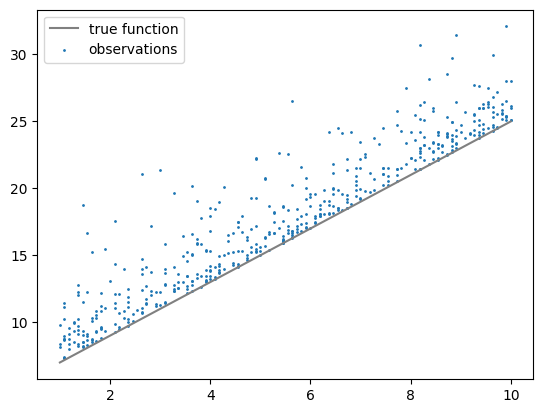

In [3]:
x = np.linspace(1,10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2., len(x_observed))

plt.plot(x, f_true(x), c='grey', label='true function')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend()

#### Getting features

In [4]:
X = get_features(x_observed, 1)
y = y_observed

# initial guess, same as linear regression fit estimate
W_ = np.linalg.pinv(X) @ y

#### Setting limits and calculating mesh

In [5]:
w0_limits = (W_[0] - 1*abs(W_[0]), W_[0] + 1*abs(W_[0]))
w1_limits = (W_[1] - 1*abs(W_[1]), W_[1] + 1*abs(W_[1]))


N = 300
w_mesh = np.meshgrid(np.linspace(*w0_limits, N), np.linspace(*w1_limits, N))
log_likelihood_mesh = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        log_likelihood_mesh[i, j] = log_likelihood(X, y, np.array([w_mesh[0][i][j], w_mesh[1][i][j]]))

#### Plotting Log Likelihood

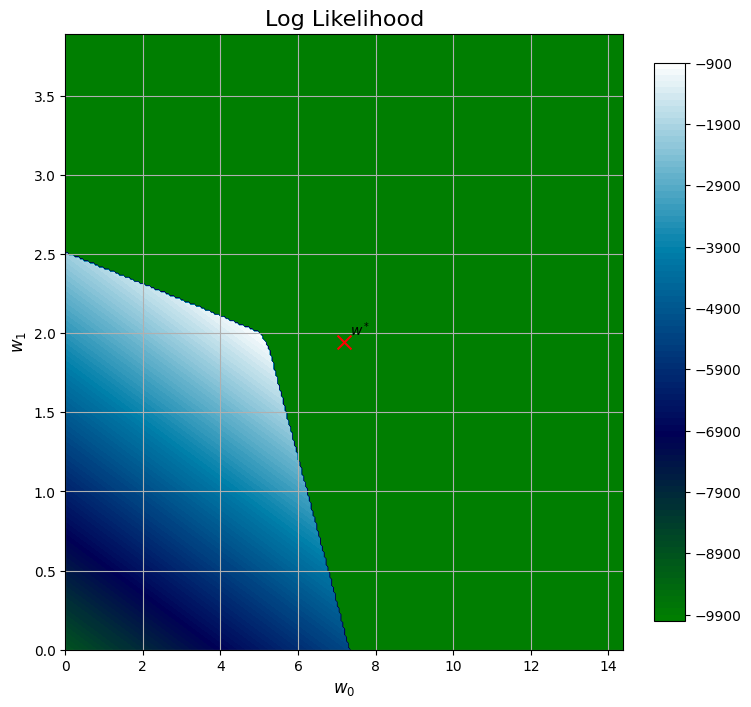

In [6]:
fig0 = plt.figure(figsize = (8,8))

cntr = plt.contourf(w_mesh[0], w_mesh[1], log_likelihood_mesh, levels = 100, cmap = plt.cm.ocean)
_ = fig0.colorbar(cntr, ax = plt.gca(), fraction = 0.05, pad = 0.05, aspect = 18)

plt.scatter(W_[0], W_[1], c='red', s=100, marker='x')
plt.annotate('$w^*$', (W_[0] + 0.02*abs(W_[0]), W_[1] + 0.02*abs(W_[1])))

plt.xlabel('$w_0$', fontsize = 12)
plt.ylabel('$w_1$', fontsize = 12)
plt.title('Log Likelihood', fontsize = 16)

plt.gca().grid(True)

#### Grid Search

In [7]:
# number of points in Grid Search per coordinate
n_pts = 20

# GS grid
w_GS = np.meshgrid(np.linspace(*w0_limits, n_pts), np.linspace(*w1_limits, n_pts))
log_likelihood_GS = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    for j in range(n_pts):
        log_likelihood_GS[i, j] = log_likelihood(X, y, np.array([w_GS[0][i][j], w_GS[1][i][j]]))

# best point
best_GS = (log_likelihood_GS.max(), (w_GS[0].flatten()[log_likelihood_GS.argmax()],
                                     w_GS[1].flatten()[log_likelihood_GS.argmax()]))

#### Random Search

In [8]:
# RS grid

w_RS = [np.random.normal(W_[0], abs(W_[0])/2, n_pts**2).reshape(n_pts, n_pts),
        np.random.normal(W_[1], abs(W_[1])/2, n_pts**2).reshape(n_pts, n_pts)]
log_likelihood_RS = np.zeros((n_pts, n_pts))
for i in range(n_pts):
    for j in range(n_pts):
        log_likelihood_RS[i, j] = log_likelihood(X, y, np.array([w_RS[0][i][j], w_RS[1][i][j]]))

# best point
best_RS = (log_likelihood_RS.max(), (w_RS[0].flatten()[log_likelihood_RS.argmax()],
                                     w_RS[1].flatten()[log_likelihood_RS.argmax()]))

#### Simplex Method Optimization

In [9]:
# function to dump points of algorithm
w_dump = [(W_[0], W_[1])]
def current_point(x):
    w_dump.append(x)
    return None

res = minimize(lambda w: -log_likelihood(X, y, w), x0=W_, method='Nelder-Mead',
                              bounds=[w0_limits, w1_limits], options={'maxiter': n_pts**2},
                              callback=current_point)

w_simp = np.array(w_dump).T
best_simp = (-res.fun, res.x)

#### Bayesian Optimization

In [10]:
# hyperparameter space
w_space = {'w0': hp.normal('w0', W_[0], abs(W_[0])/2),
           'w1': hp.normal('w1', W_[1], abs(W_[1])/2)}

n_evals = n_pts**2
trls = Trials()

res_BO = fmin(lambda hps: -log_likelihood(X,y, np.array([hps['w0'], hps['w1']])), space = w_space, algo = tpe.suggest,
              trials = trls, max_evals=n_evals)

w_BO = [np.array([x['misc']['vals']['w0'] for x in trls.trials]),
        np.array([x['misc']['vals']['w1'] for x in trls.trials])]

best_BO = (-trls.best_trial['result']['loss'], (space_eval(w_space, res_BO)['w0'],
                                                space_eval(w_space, res_BO)['w1']))

100%|██████████| 400/400 [00:00<00:00, 559.39trial/s, best loss: 961.1318358411316] 


#### Results

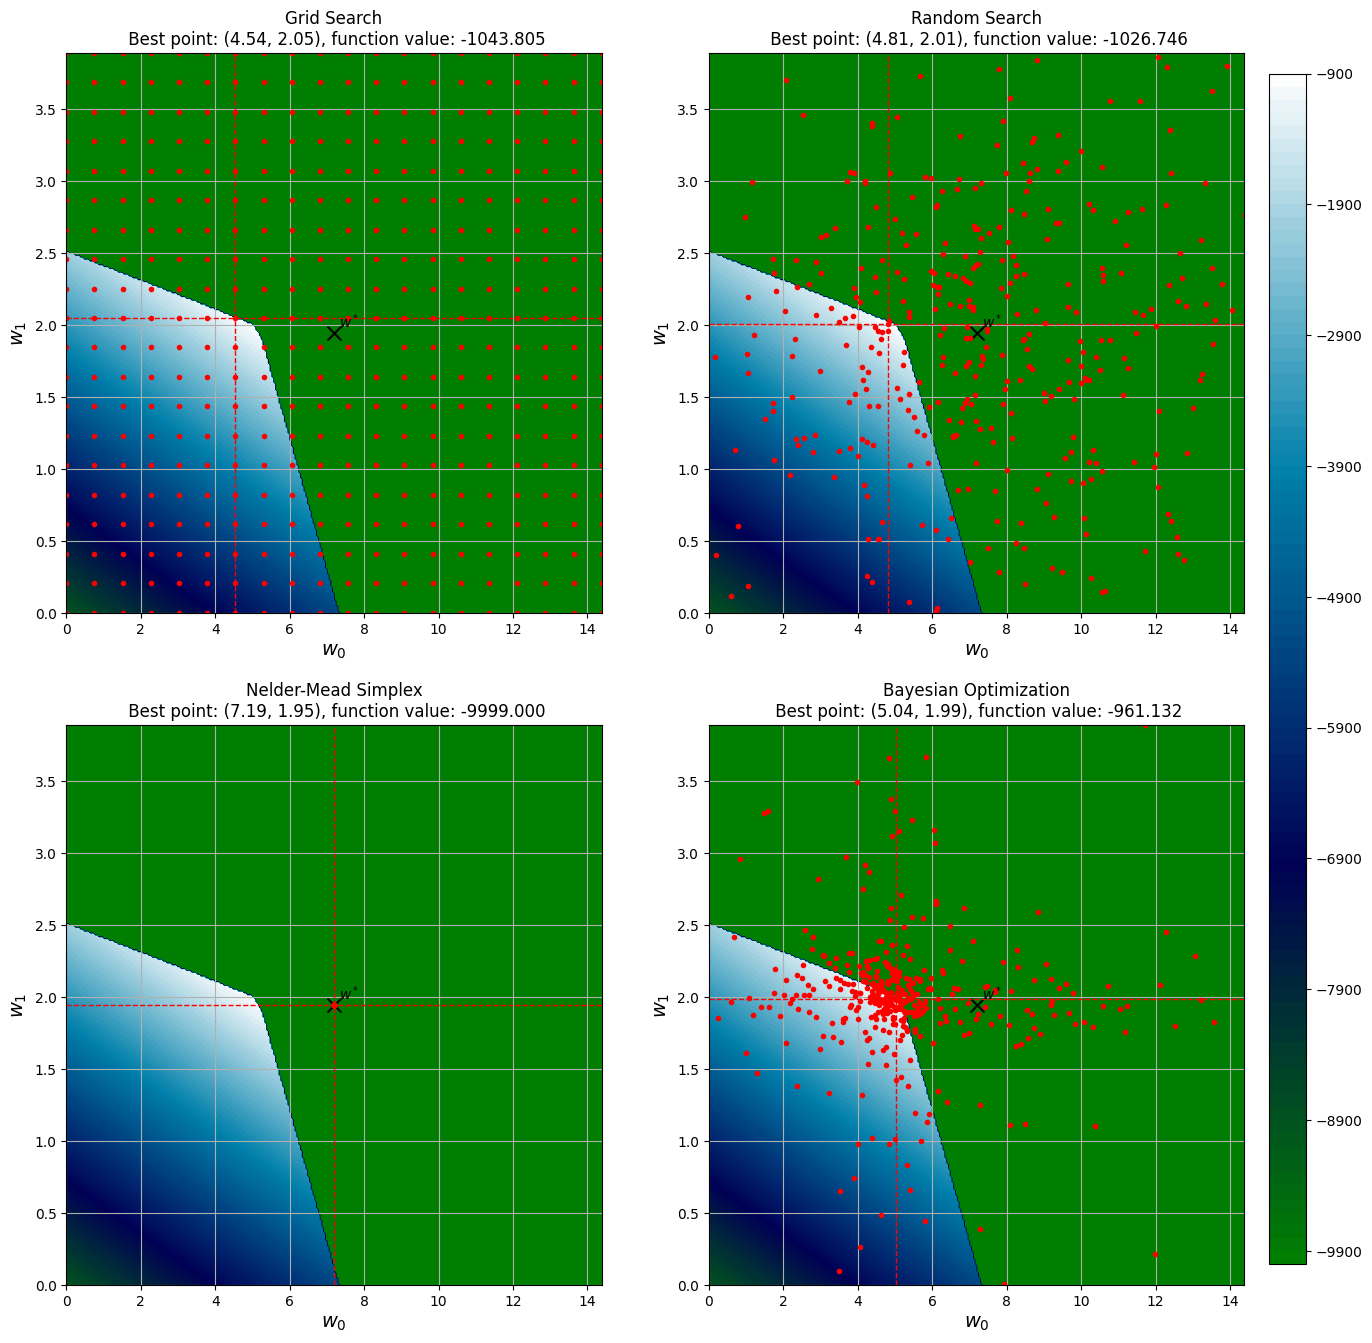

In [11]:
fig0, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
labels = ('Grid Search', 'Random Search', 'Nelder-Mead Simplex', 'Bayesian Optimization')

for (w_val, w_label, w_best, ax) in zip((w_GS, w_RS, w_simp, w_BO),
                                      labels,
                                      (best_GS, best_RS, best_simp, best_BO),
                                      axs.flatten()):
    # log likelihood mesh
    cntr = ax.contourf(w_mesh[0], w_mesh[1], log_likelihood_mesh, levels = 100, cmap = plt.cm.ocean)
    ax.plot(w_val[0], w_val[1], linewidth=0, marker='.', color='red')

    # w* point
    ax.scatter(W_[0], W_[1], c='black', s=100, marker='x')
    ax.annotate('$w^*$', (W_[0] + 0.02*abs(W_[0]), W_[1] + 0.02*abs(W_[1])))

    # best results
    ax.plot(w0_limits, [w_best[1][1]]*2, linewidth=1, linestyle='--', color='red')
    ax.plot([w_best[1][0]]*2, w1_limits, linewidth=1, linestyle='--', color='red')

    # axes formatting
    ax.set_xlim(w0_limits)
    ax.set_ylim(w1_limits)

    ax.set_xlabel('$w_0$', fontsize=14)
    ax.set_ylabel('$w_1$', fontsize=14)

    ax.set_title('{0}\n Best point: ({1:.2f}, {2:.2f}), function value: {3:.3f}'.format(
        w_label, *w_best[1], w_best[0]))
    
    ax.grid(True)
    
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=32)

credits to [this Kaggle notebook](kaggle.com/code/prashant111/bayesian-optimization-using-hyperopt)

#### Bayesian Optimization Results

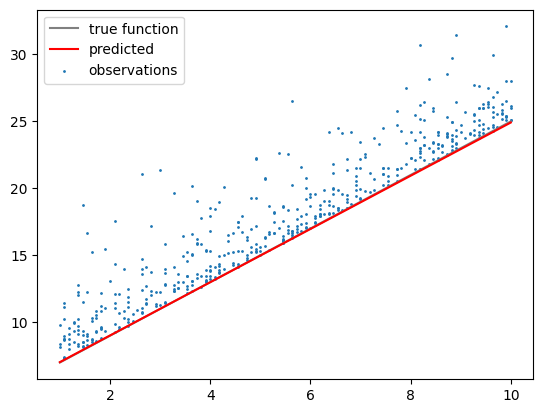

In [19]:
plt.plot(x, f_true(x), c='grey', label='true function')
plt.plot(x, get_features(x, 1) @ best_BO[1], c='red', label='predicted')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend();

In [27]:
np.abs(f_true(x) - get_features(x, 1) @ best_BO[1]).max().round(4)

0.0824

#### Linear Programming

In [20]:
bbox = np.array([list(w0_limits), list(w1_limits)])

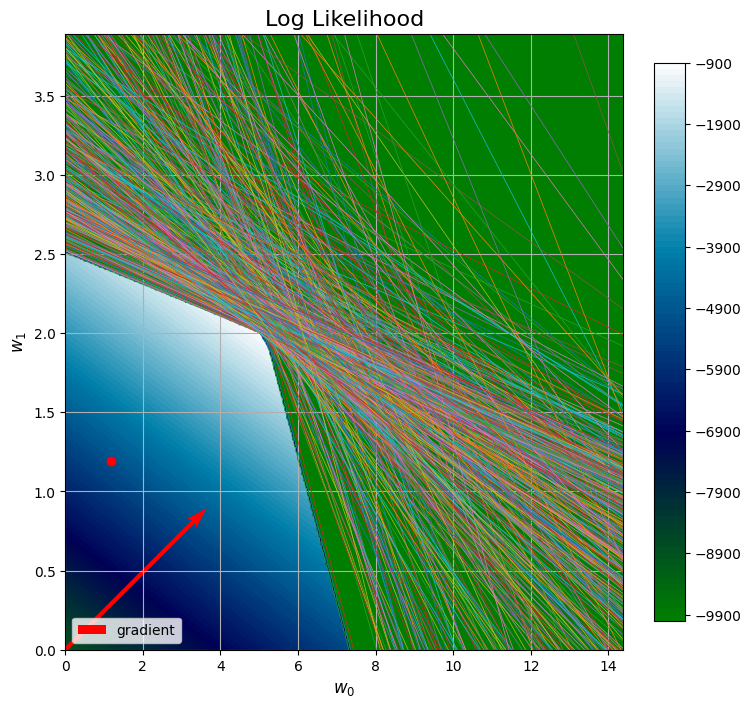

In [21]:
fig0, ax = plt.subplots()
fig0.set_size_inches((8,8))

cntr = ax.contourf(w_mesh[0], w_mesh[1], log_likelihood_mesh, levels = 100, cmap = plt.cm.ocean)
_ = fig0.colorbar(cntr, ax = plt.gca(), fraction = 0.05, pad = 0.05, aspect = 18)

points, interior_point, hs = plot_inequalities(X, y, bbox, ax);
grad = (log_likelihood(X, y, interior_point) - log_likelihood(X, y, interior_point - 0.01)) / (np.ones_like(interior_point)) / 0.01
grad = grad/np.linalg.norm(grad)

ax.quiver(*[0,0], *grad, scale=0.5, scale_units='inches', color='red', label='gradient')

plt.xlabel('$w_0$', fontsize = 12)
plt.ylabel('$w_1$', fontsize = 12)
ax.set_title('Log Likelihood', fontsize = 16)

plt.gca().grid(True)


ax.legend();

In [22]:
# brute search near all vertices of convex hull

best_linprog = None, np.inf

for W in np.array(points):
    slices = [slice(w - abs(w)/100 - 1e-15, w + abs(w)/100 + 1e-15, abs(w)/500+1e-15) for w in W]
    res_brute = brute(
        lambda W: -log_likelihood(X, y_observed, np.array(W)),
        ranges=slices,
        full_output=True
    )

    if -res_brute[1] > -best_linprog[1]:
        best_linprog = res_brute

w_linporg = best_linprog[0]

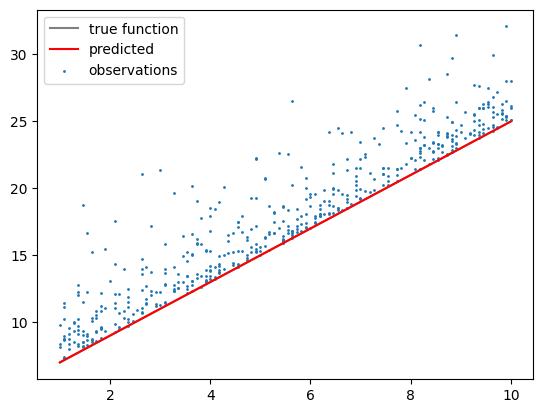

In [23]:
plt.plot(x, f_true(x), c='grey', label='true function')
plt.plot(x, get_features(x, 1) @ w_linporg, c='red', label='predicted')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend();

In [26]:
np.abs(f_true(x) - get_features(x, 1) @ w_linporg).max().round(4)

0.00799

#### 3 parameters

#### Data generation and plotting

In [28]:
def f_true(x):
    return (x - 3) ** 2

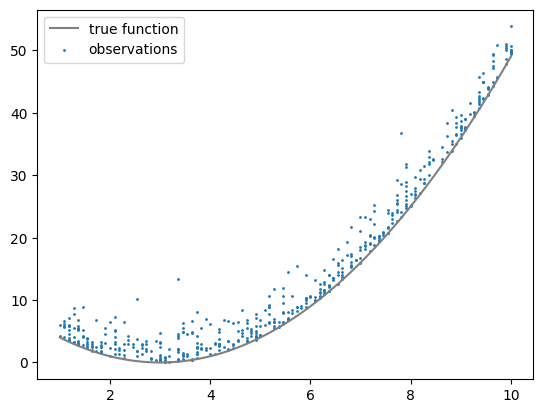

In [29]:
x = np.linspace(1,10, 100)
x_observed = np.random.choice(x, size=500, replace=True)
y_observed = f_true(x_observed) + np.random.exponential(2., len(x_observed))

plt.plot(x, f_true(x), c='grey', label='true function')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend();

#### Getting features

In [30]:
X = get_features(x_observed, 2)
y = y_observed

# initial guess, same as linear regression fit estimate
W_ = np.linalg.pinv(X) @ y

#### Bayesian Optimization

In [31]:
# hyperparameter space
w_space = {'w0': hp.normal('w0', W_[0], abs(W_[0])/2),
           'w1': hp.normal('w1', W_[1], abs(W_[1])/2),
           'w2': hp.normal('w2', W_[2], abs(W_[2])/2)}

n_evals = n_pts**2
trls = Trials()

res_BO = fmin(lambda hps: -log_likelihood(X,y, np.array([hps['w0'], hps['w1'], hps['w2']])), space = w_space, algo = tpe.suggest,
              trials = trls, max_evals=n_evals)

w_BO = [np.array([x['misc']['vals']['w0'] for x in trls.trials]),
        np.array([x['misc']['vals']['w1'] for x in trls.trials]),
        np.array([x['misc']['vals']['w2'] for x in trls.trials])]

best_BO = (-trls.best_trial['result']['loss'], (space_eval(w_space, res_BO)['w0'],
                                                space_eval(w_space, res_BO)['w1'],
                                                space_eval(w_space, res_BO)['w2']))

  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 400/400 [00:01<00:00, 398.92trial/s, best loss: 1229.498683051956] 


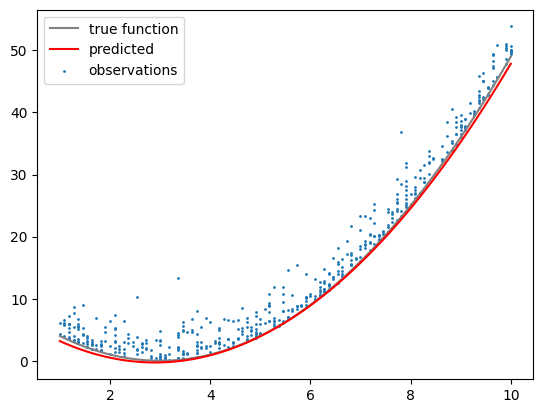

In [33]:
plt.plot(x, f_true(x), c='grey', label='true function')
plt.plot(x, get_features(x, 2) @ best_BO[1], c='red', label='predicted')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend();

In [34]:
np.abs(f_true(x) - get_features(x, 2) @ best_BO[1]).max().round(4)

1.1519

#### Linear Programming

In [36]:
bbox = np.array([(w - abs(w), w + abs(w)) for w in W_])

In [37]:
points, interior_point, hs = solve_convex_set(X, y, bbox)

In [38]:
best_linprog = None, np.inf

for W in np.array(points):
    slices = [slice(w - abs(w)/100 - 1e-15, w + abs(w)/100 + 1e-15, abs(w)/500+1e-15) for w in W]
    res_brute = brute(
        lambda W: -log_likelihood(X, y_observed, np.array(W)),
        ranges=slices,
        full_output=True
    )

    if -res_brute[1] > -best_linprog[1]:
        best_linprog = res_brute

w_linporg = best_linprog[0]

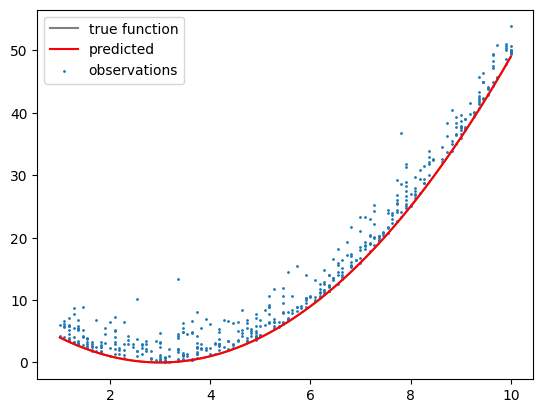

In [39]:
plt.plot(x, f_true(x), c='grey', label='true function')
plt.plot(x, get_features(x, 2) @ w_linporg, c='red', label='predicted')
plt.scatter(x_observed, y_observed, s = 1., label='observations')
plt.legend();

In [40]:
np.abs(f_true(x) - get_features(x, 2) @ w_linporg).max().round(4)

0.0141